This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [1]:
#%run 0_parameters.ipynb

In [2]:
figname = '../paper/fig_result'

# Training the Where network

In [3]:
%ls -lh ../data/*pt

-rw-r--r--  1 laurentperrinet  staff    12M Mar 13 22:14 ../data/2019-03-13_train.pt
-rw-r--r--  1 laurentperrinet  staff    12M Mar 14 17:44 ../data/2019-03-14_b_train.pt
-rw-r--r--  1 laurentperrinet  staff    12M Mar 14 06:17 ../data/2019-03-14_train.pt
-rw-r--r--  1 laurentperrinet  staff    12M Mar 14 14:54 ../data/2019-03-14_train3.pt
-rw-r--r--  1 laurentperrinet  staff    12M Mar 14 19:28 ../data/2019-03-14_train4.pt
-rw-r--r--  1 laurentperrinet  staff    12M Mar 15 22:18 ../data/2019-03-15_train.pt
-rw-r--r--  1 laurentperrinet  staff    12M Mar 15 15:31 ../data/2019-03-15_train_b.pt
-rw-r--r--  1 laurentperrinet  staff   8.8M Mar 20 17:46 ../data/2019-03-16_train.pt
-rw-r--r--@ 1 laurentperrinet  staff    12M Mar 19 00:19 ../data/2019-03-18_train.pt
-rw-r--r--  1 laurentperrinet  staff    12M Mar 19 15:18 ../data/2019-03-19_bis_train.pt
-rw-r--r--  1 laurentperrinet  staff    12M Mar 19 15:54 ../data/2019-03-19_train.pt
-rw-r--r--  1 laurentperrinet  staff    12M Mar 27 16:3

In [4]:
from main import init
#args = init(filename='debug')
#args = init()
#args = init(filename='../data/2019-03-29')
args = init(filename='../data/2019-04-01')

period = 10
args.sf_0 = 1/period
args.B_sf = 1/period
args.contrast = 0.7
args.bn1_bn_momentum = 0
args.bn2_bn_momentum = 0
args.p_dropout = 0.5
args.dim1 = 1000
args.dim2 = 1000
args.epochs = 60
args.N_eccentricity = 10
args.verbose = True
from where import Where
from what import WhatNet


In [5]:
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.5,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0,
 'bn2_bn_momentum': 0,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 0,
 'verbose': True,
 'filename': '../data/2019-04-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True}

In [6]:
if False:
    !rm ../data/2019-04-05_train.pt


In [7]:
args.epochs = 60

In [8]:
#args.train_batch_size = 20
#args.test_batch_size = 20
where = Where(args, batch_load = True) #False, save = False)

filename_train = args.filename + '_train.pt'
#filename_train = "../data/2019-03-14_train4.pt"
#filename_train = "../data/2019-03-29.pt"
%ls -lh {filename_train}
#%rm {filename_train}
#%rm  ../data/debug_train.pt

where.train(filename_train)

Loading accuracy... min, max= 0.0145 0.9852
Loading training dataset
Loading testing dataset
-rw-r--r--  1 laurentperrinet  staff   5.7M Apr  8 23:09 ../data/2019-04-01_train.pt
Loading file ../data/2019-04-01_train.pt


In [9]:
args.contrast

0.7

In [10]:
where

# Visualisation of some examples

In [11]:
data, label = next(iter(where.display.loader_test))
idx_start, idx_stop = 0, 20

#

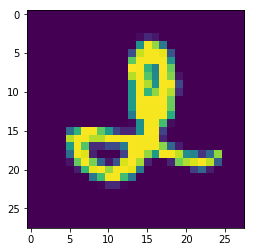

In [12]:
import matplotlib.pyplot as plt
plt.imshow(data[0].detach().numpy().reshape(28, 28))

In [13]:
retina_data, accuracy_colliculus = next(iter(where.loader_train))

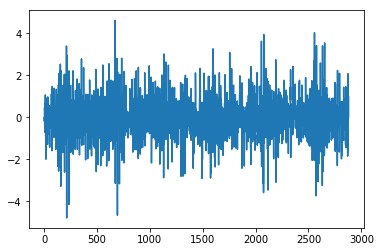

In [14]:
plt.plot(retina_data[0,:].detach().numpy())

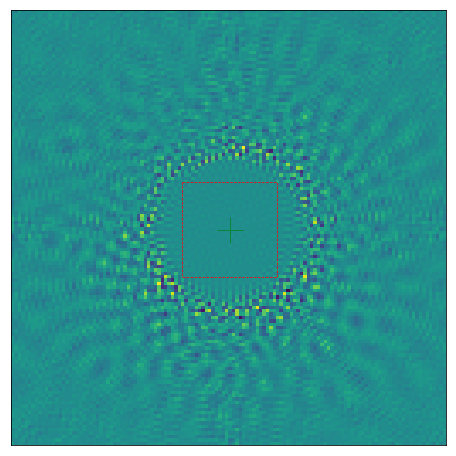

In [15]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111)
ax = where.retina.show(ax, where.retina.retina_invert(retina_data[0,:].detach().numpy()))


Text(0.5, 1.05, 'True')

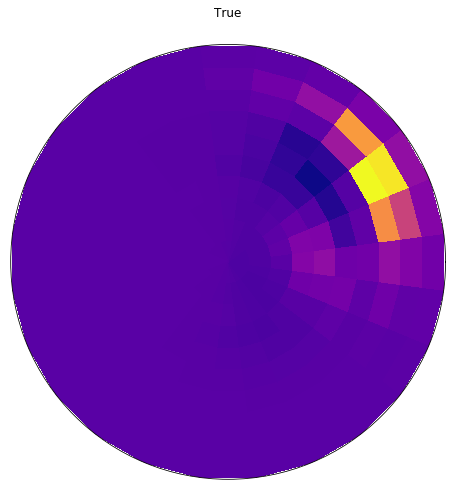

In [16]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='polar')
ax.pcolor(where.retina.theta, where.retina.log_r, accuracy_colliculus[0, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("True")

In [17]:
retina_data.shape

torch.Size([100, 2880])

In [18]:
min(accuracy_colliculus[3,:])

tensor(0.0669)

In [19]:
positions, data_fullfield, retina_data, accuracy_colliculus = where.minibatch(data[idx_start:idx_stop])

In [20]:
print(accuracy_colliculus.shape)
print(args.N_azimuth)
print(args.N_eccentricity) 

print(where.args.N_azimuth)
print(where.args.N_eccentricity) 

torch.Size([20, 240])
24
10
24
10


## knowing the target position

In [21]:
import numpy as np

#im = np.zeros((args.test_batch_size, args.w, args.w))
im = np.zeros((idx_stop, where.args.w, where.args.w))
for idx in range(idx_stop): #args.test_batch_size):
    im[idx, :, :] = where.extract(data_fullfield[idx, :, :], positions[idx]['i_offset'], positions[idx]['j_offset'])
proba = where.classify_what(im).detach().numpy()
pred = proba.argmax(axis=1)# get the index of the max log-probability
#acc = proba[:, pred]

print(pred)
label_n = label[idx_start:idx_stop].detach().numpy()
print(label_n)
print(np.mean(np.equal(pred, label_n)))

#.detach().numpy().mean() #(pred==label.numpy()).mean()
#print('Accuracy max (knowing the position)=', acc_max)

[8 1 5 7 6 9 8 3 8 1 2 6 8 7 5 7 4 2 9 2]
[2 1 5 7 6 9 8 3 1 1 2 6 8 7 1 7 4 2 9 2]
0.85


## Generate a noisy MNIST database

In [22]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import os

#im = np.zeros((args.test_batch_size, args.w, args.w))

from retina import get_data_loader
filename_dataset = '../data/noisy-MNIST.pt'

if not os.path.isfile(filename_dataset):
    batch_size = 100
    loader_full = get_data_loader(batch_size=batch_size, train=True, mean=where.args.mean, std=where.args.std, seed=where.args.seed+1)
    im = np.zeros((where.args.train_batch_size, 1, where.args.w, where.args.w))
    im_label = np.zeros(where.args.train_batch_size, dtype = 'int')
    for idx, (data, label) in enumerate (loader_full):
        if idx % 10 == 0:
            print(idx * 100)
        if idx == 500:
            break
        for j in range(batch_size):
            data_fullfield_, i_offset, j_offset = where.display.draw(data[j, 0, :, :].numpy())
            extracted = where.extract(data_fullfield_, i_offset, j_offset)
            im[idx * batch_size + j, 0, :, :] = extracted.reshape(1, 28, 28)
            im_label[idx * batch_size + j] = label[j]
    im = Variable(torch.FloatTensor(im)).to(where.device)
    im_label = Variable(torch.LongTensor(im_label)).to(where.device)
    loader_train = DataLoader(TensorDataset(im, im_label), batch_size=100)
    torch.save(loader_train, filename_dataset)
#.detach().numpy().mean() #(pred==label.numpy()).mean()
#print('Accuracy max (knowing the position)=', acc_max)

In [23]:
if False:
    check_loader = torch.load(filename_dataset)
    im, label = next(iter(check_loader))
    im.shape
    i = 4
    plt.imshow(im[i,0,:,:])
    plt.title(label[i].detach().numpy())

{'i_offset': -17, 'j_offset': 29} tensor(2)


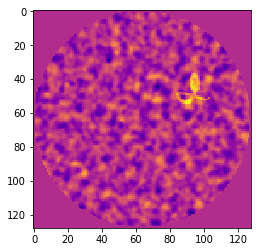

In [24]:
idx = 0
plt.imshow(data_fullfield[idx,:,:])
print(positions[idx], label[idx])

In [25]:
idx_start, idx_stop = 0, 20

#from main_orig import init
#args = init()
#args.N_azimuth * args.N_eccentricity

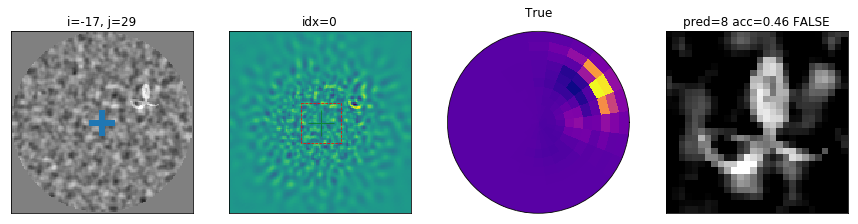

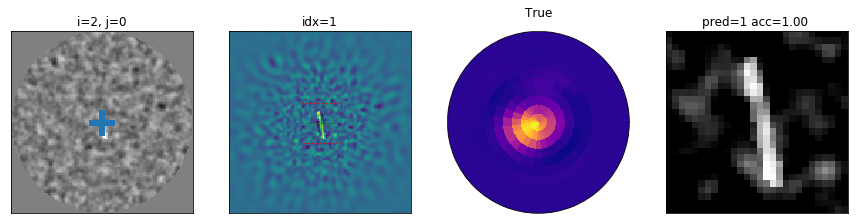

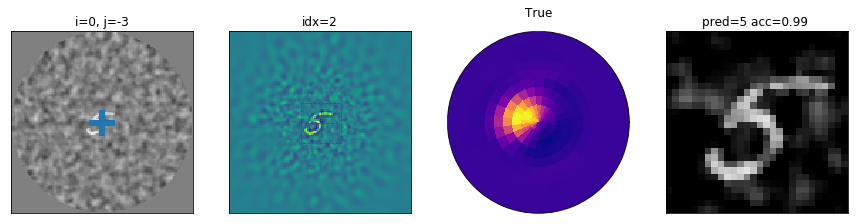

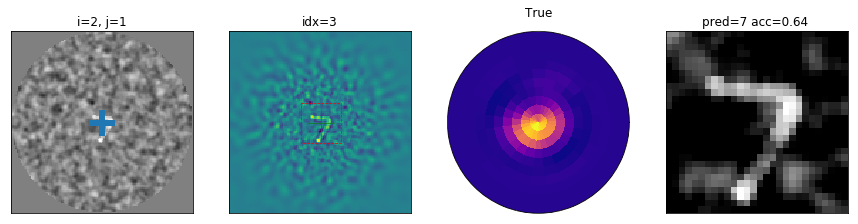

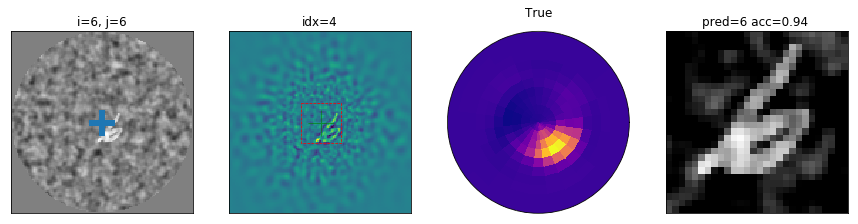

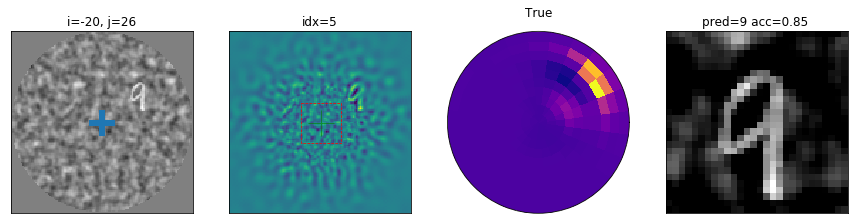

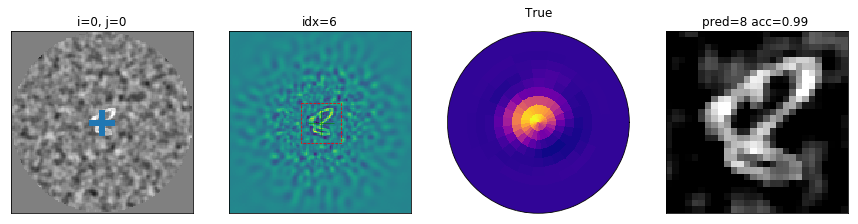

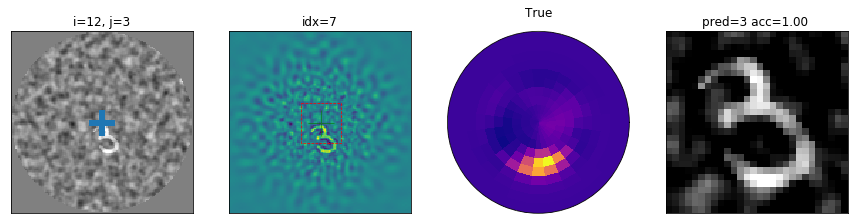

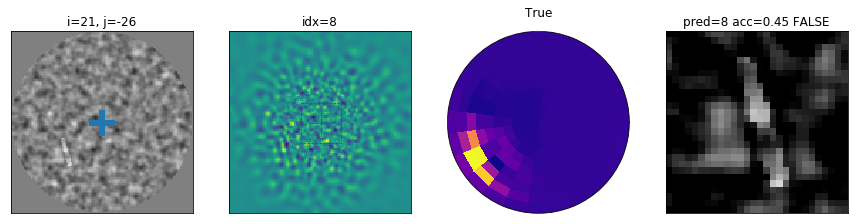

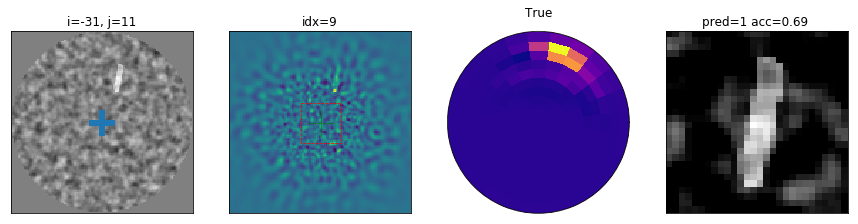

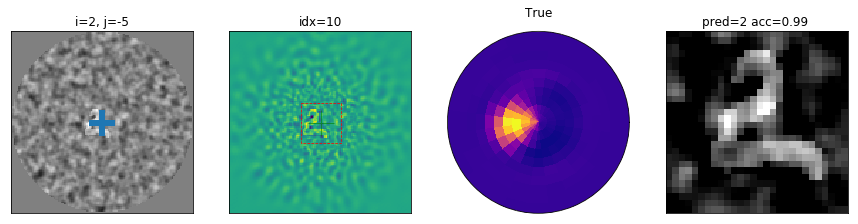

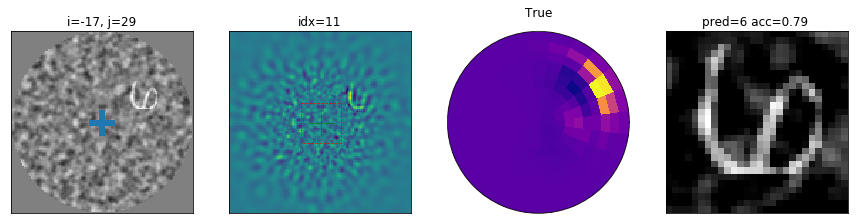

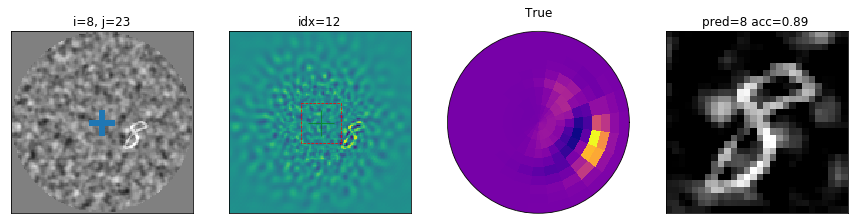

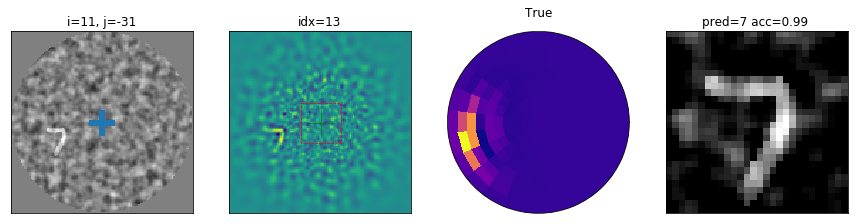

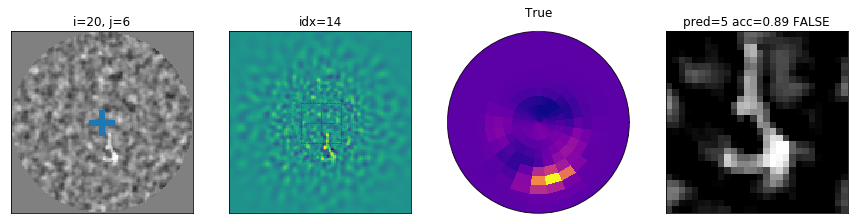

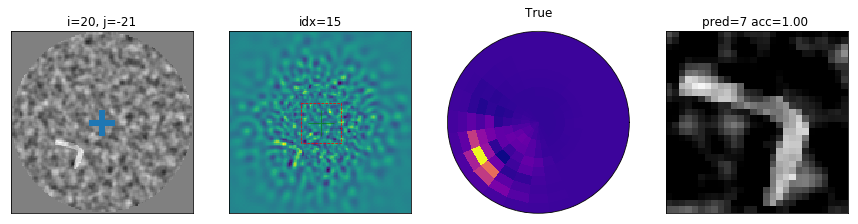

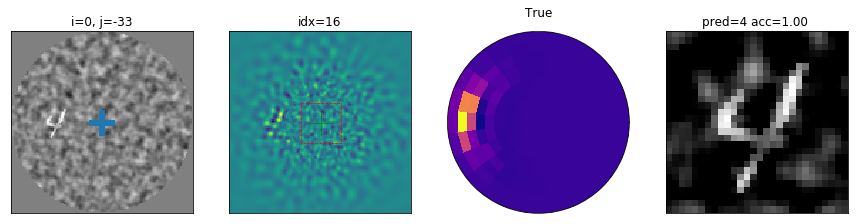

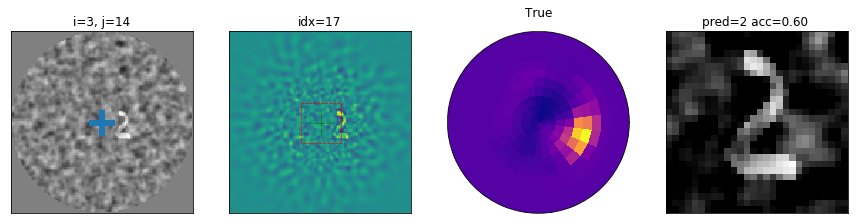

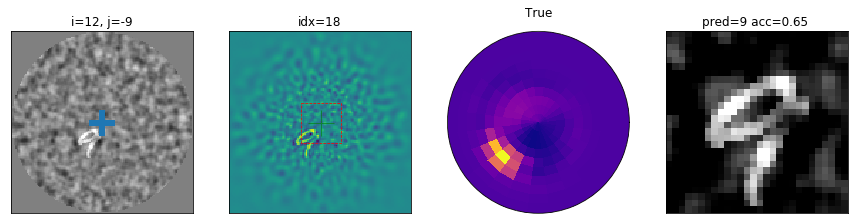

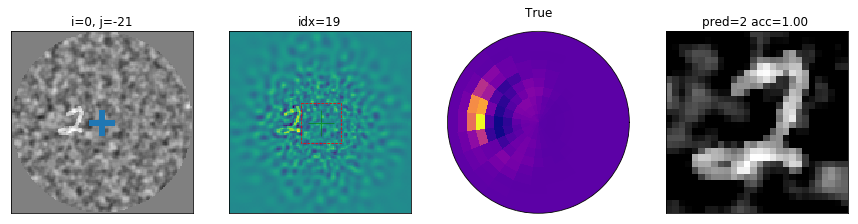

In [26]:
for idx in range(idx_start, idx_stop):
    fig = plt.figure(figsize = (15, 8))
    
    ax = fig.add_subplot(141)
    ax = where.display.show(ax, data_fullfield[idx, :, :])
    ax.set_title(f"i={positions[idx]['i_offset']}, j={positions[idx]['j_offset']}")
    
    ax = fig.add_subplot(142)
    data_retina = where.retina.retina(data_fullfield[idx, :, :])
    ax = where.retina.show(ax, where.retina.retina_invert(data_retina))
    ax.set_title(f"idx={idx}")
              
    ax = fig.add_subplot(143, projection='polar')
    ax.pcolor(where.retina.theta, where.retina.log_r, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title("True")

    ax = fig.add_subplot(144)
    ax = where.display.show(ax, im[idx, :, :], do_cross=False)
    result = '' if pred[idx]==label[idx].numpy() else 'FALSE'
    ax.set_title(f"pred={pred[idx]} acc={proba[idx,pred[idx]]:.2f} {result}")
                 

## predicting the position of the target

In [27]:
pred_accuracy_colliculus = where.pred_accuracy(retina_data)
print('pred_accuracy_colliculus.shape=', pred_accuracy_colliculus.shape)

pred_accuracy_colliculus.shape= (20, 240)


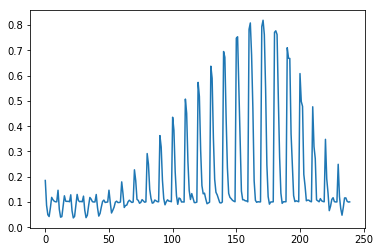

In [28]:
plt.plot(pred_accuracy_colliculus[2,:])

In [29]:
im_colliculus = where.retina.accuracy_invert(pred_accuracy_colliculus[0,:])
im_colliculus.shape

(128, 128)

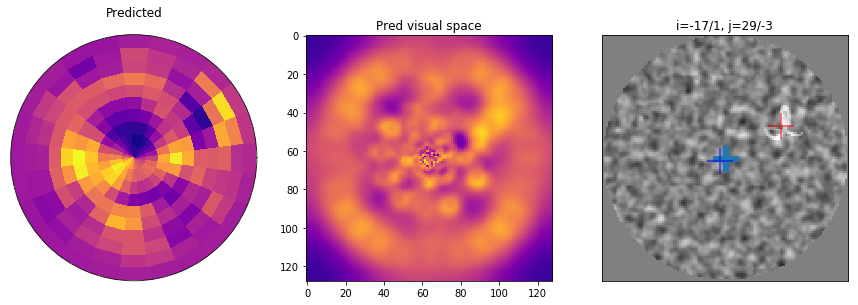

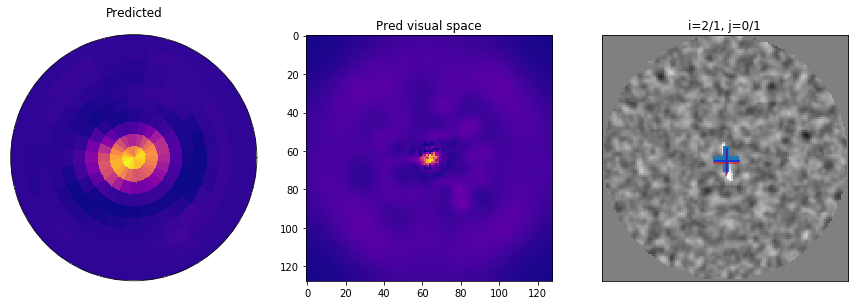

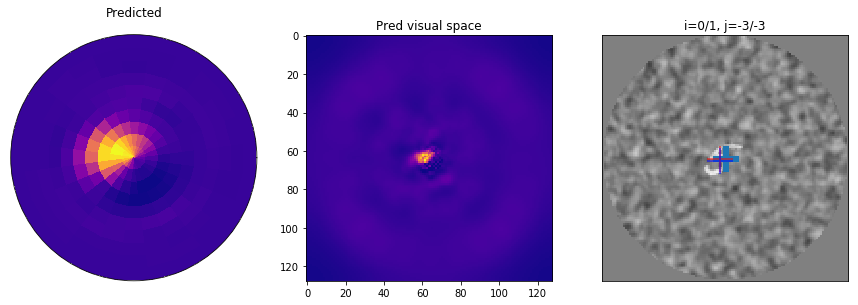

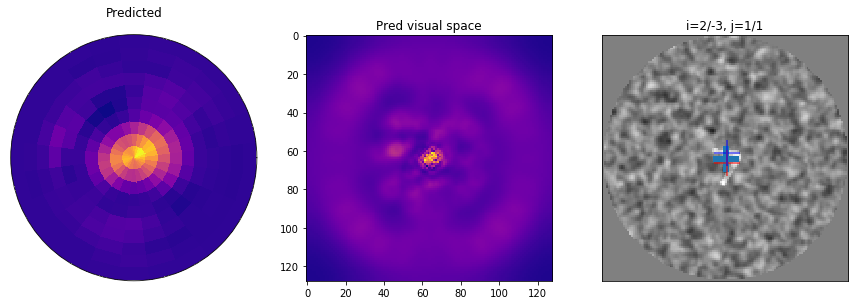

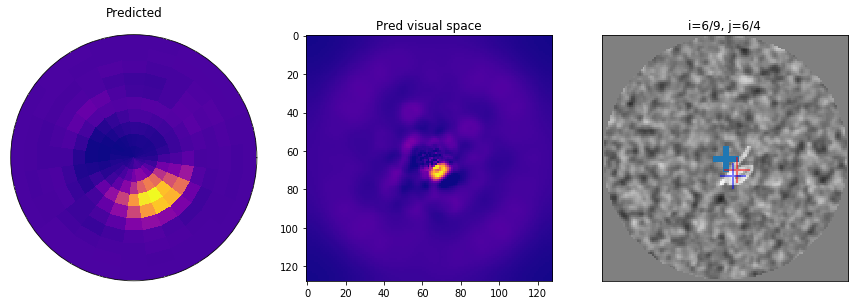

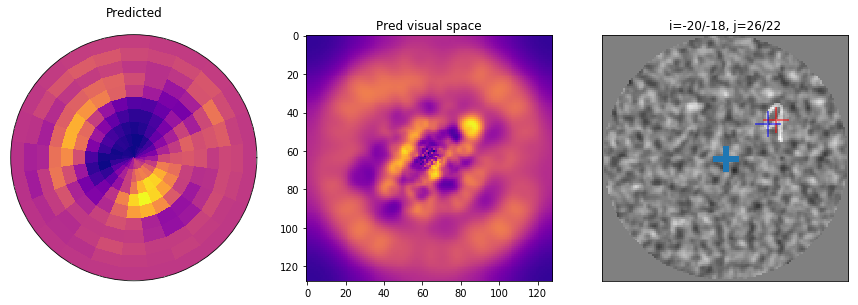

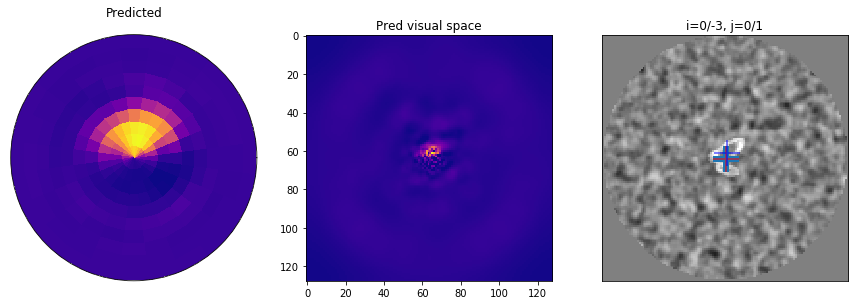

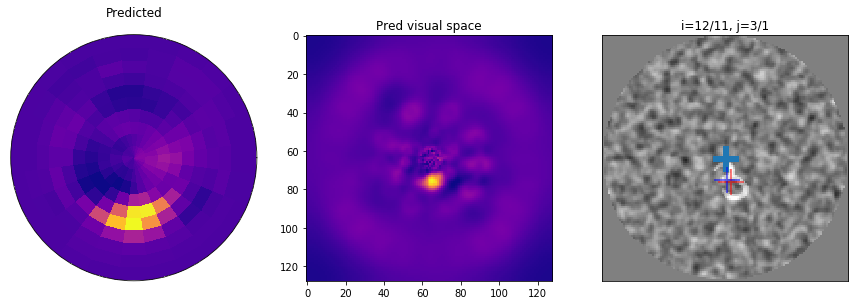

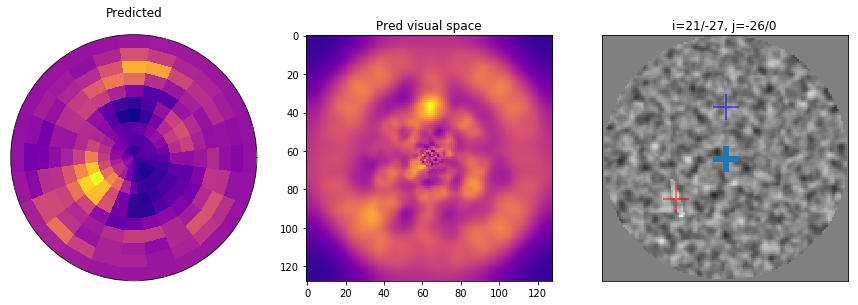

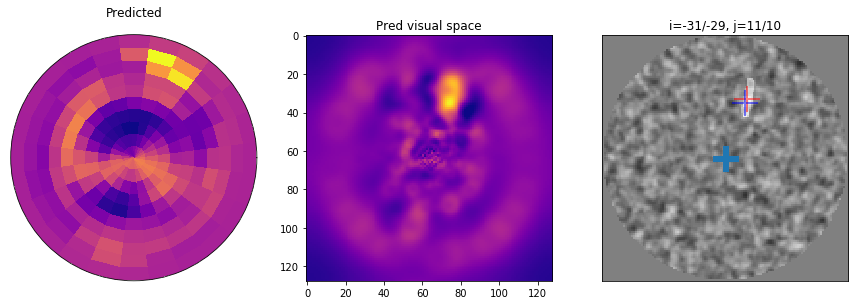

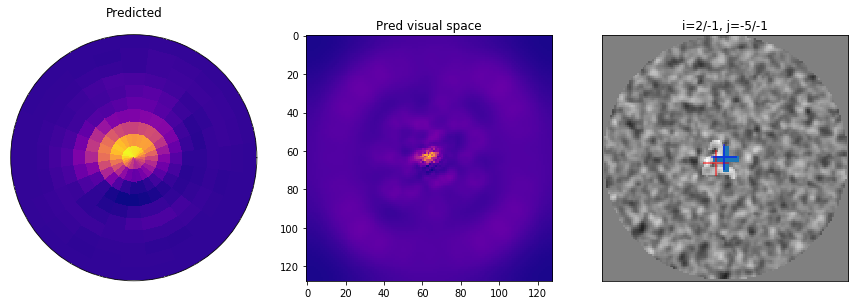

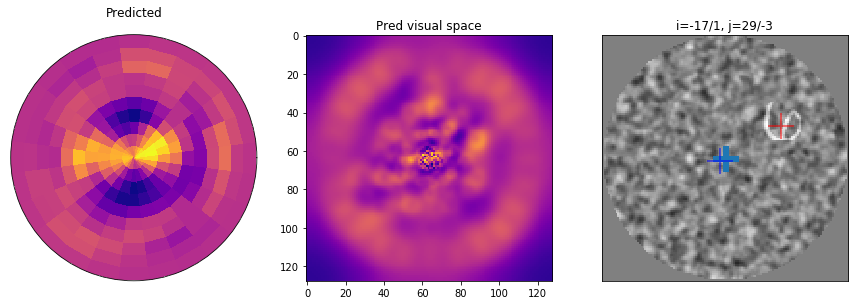

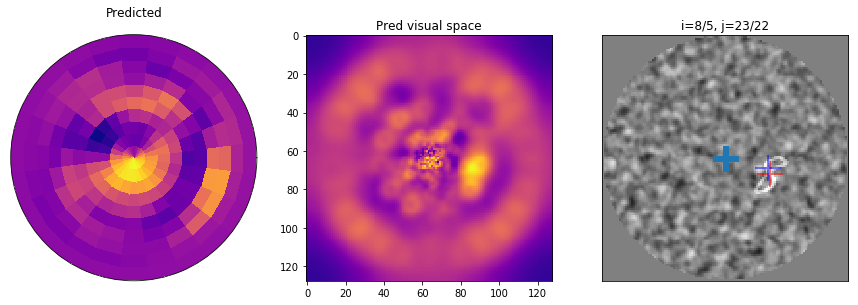

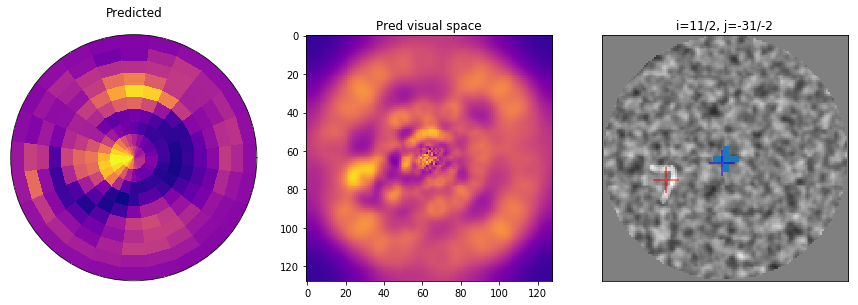

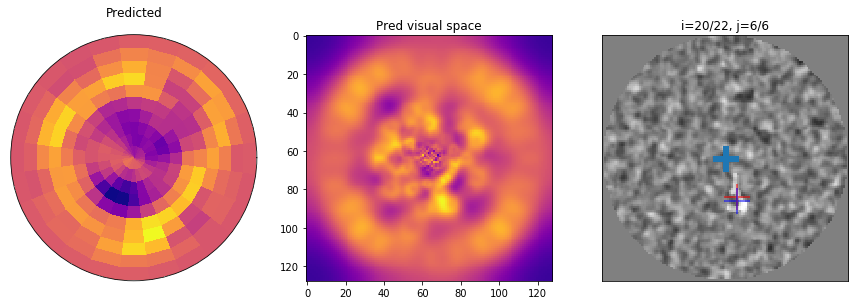

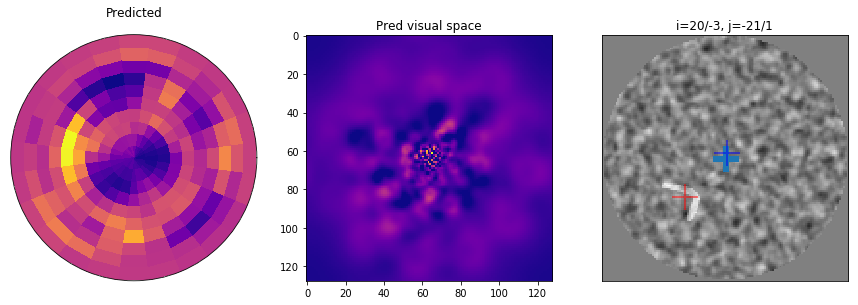

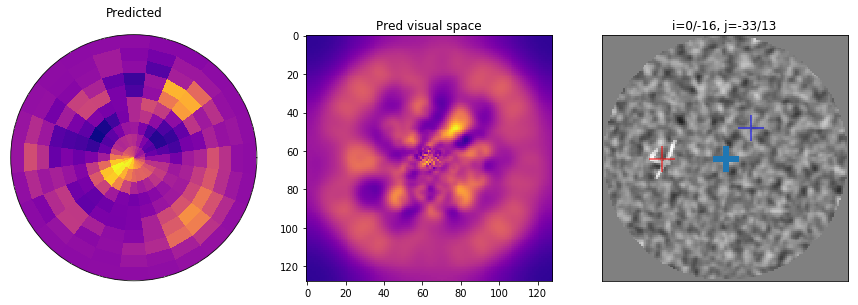

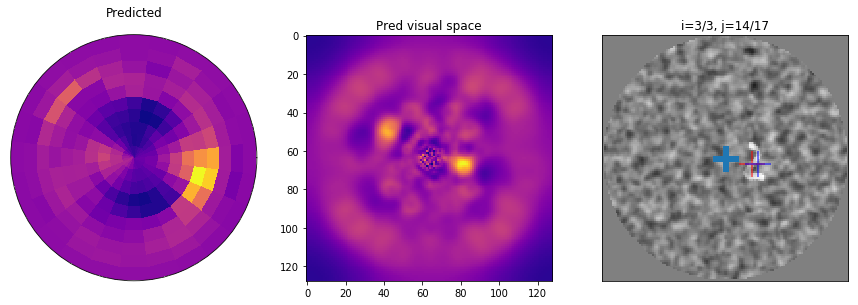

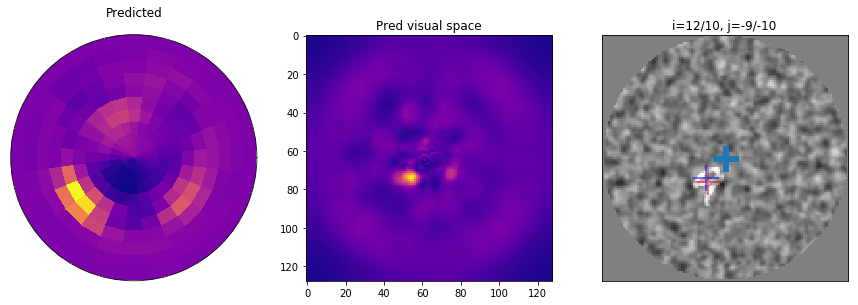

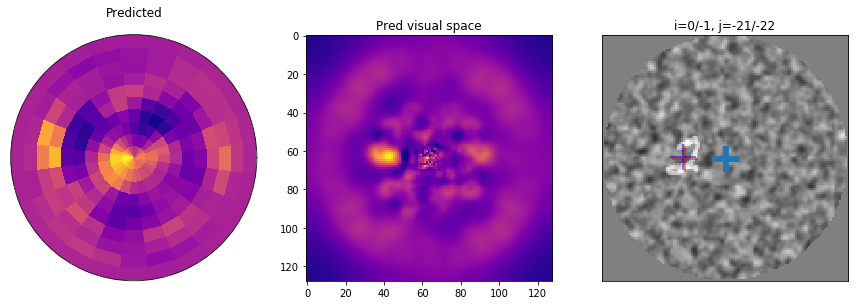

In [30]:
for idx in range(idx_start, idx_stop):
    fig = plt.figure(figsize = (15, 8))

    ax = fig.add_subplot(131, projection='polar')
    ax.pcolor(where.retina.theta, where.retina.log_r, pred_accuracy_colliculus[idx, :].reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_title("Predicted")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
              
    x = where.retina.accuracy_invert(pred_accuracy_colliculus[idx, :])
    ax = fig.add_subplot(132)
    ax.imshow(x, vmin=0, cmap=plt.plasma())
    ax.set_title("Pred visual space")
    
    i_pred, j_pred = where.index_prediction(pred_accuracy_colliculus[idx, :])
    
    ax = fig.add_subplot(133)
    ax = where.display.show(ax, data_fullfield[idx, :, :])
    ax.set_title(f"i={positions[idx]['i_offset']}/{i_pred}, j={positions[idx]['j_offset']}/{j_pred}")
    ax.plot([positions[idx]['j_offset']+args.N_pic//2], [positions[idx]['i_offset']+args.N_pic//2], '+', c='r', ms=26, markeredgewidth=2, alpha=.5)
    ax.plot([j_pred+args.N_pic//2], [i_pred+args.N_pic//2], '+', c='b', ms=26, markeredgewidth=2, alpha=.5)
    
    

## doing a saccade at the predicted the position of the target

In [31]:
print(data_fullfield.shape, retina_data.shape, label.shape)

(20, 128, 128) torch.Size([20, 2880]) torch.Size([10000])


In [32]:
accuracy = where.test_what(data_fullfield, pred_accuracy_colliculus, label)
#print('mean accuracy =', accuracy.mean())
accuracy

0.0

In [33]:
label

tensor([2, 1, 5,  ..., 8, 5, 8])

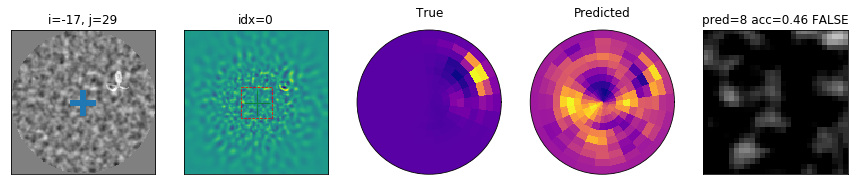

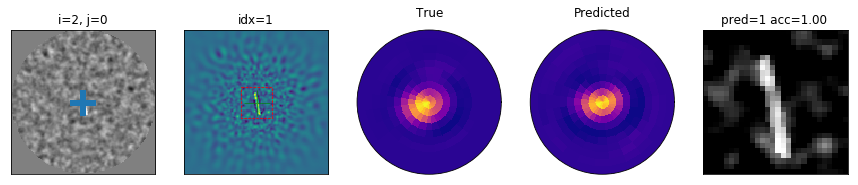

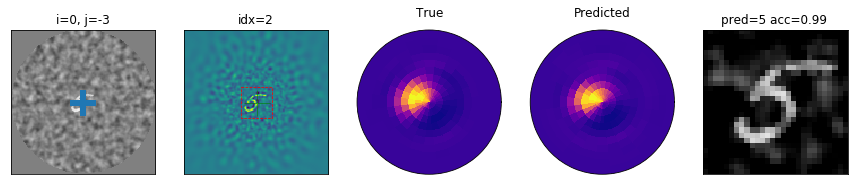

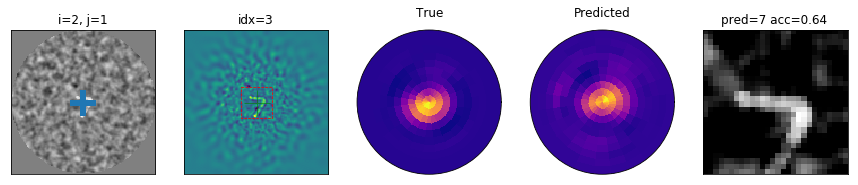

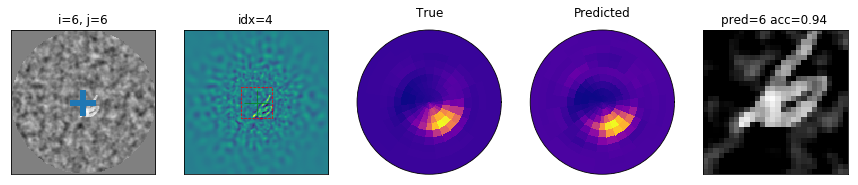

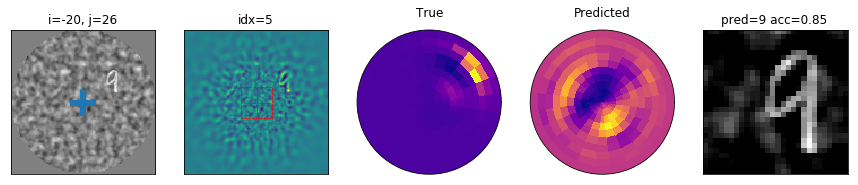

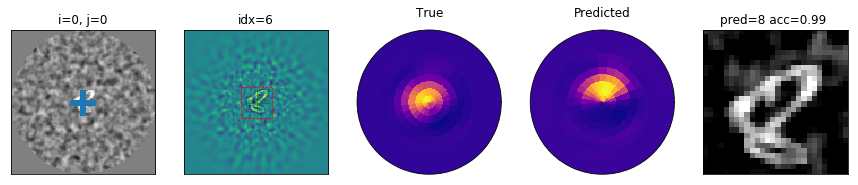

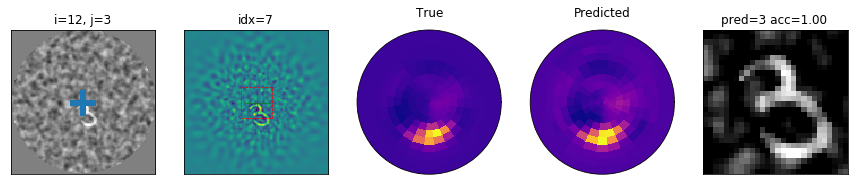

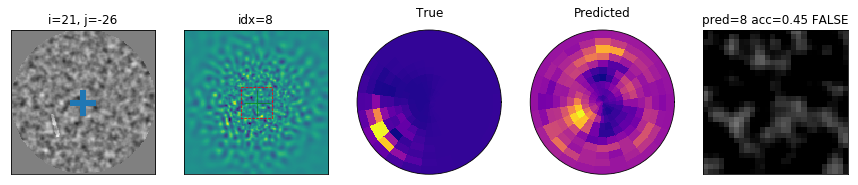

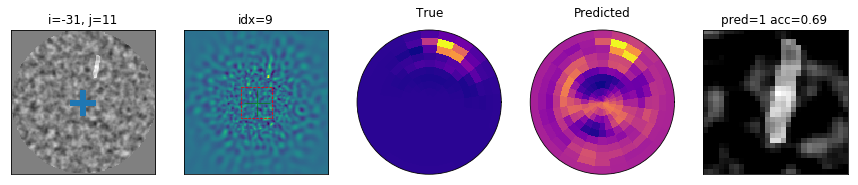

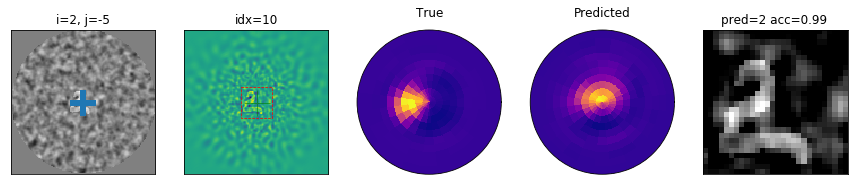

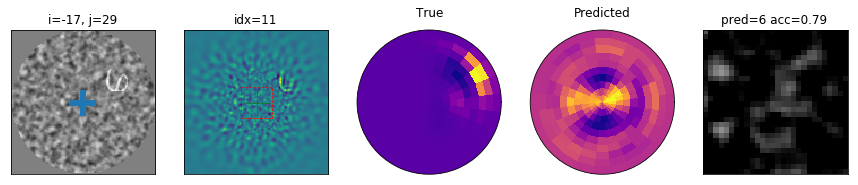

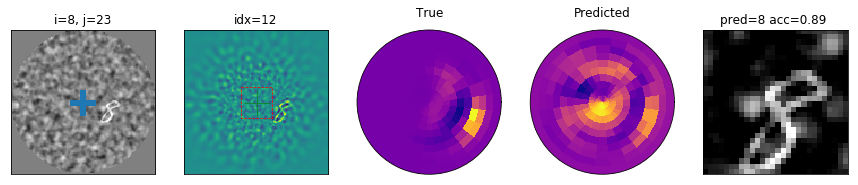

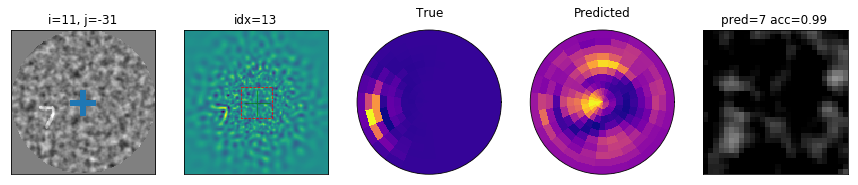

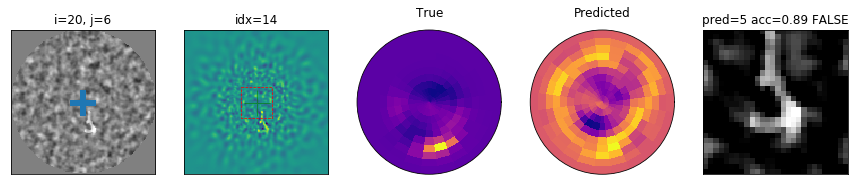

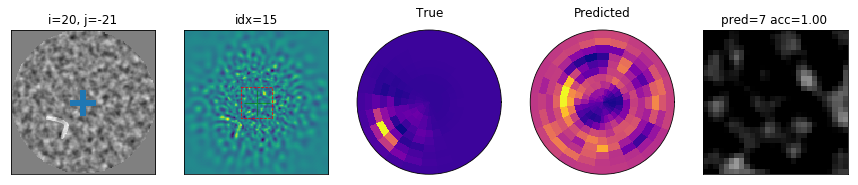

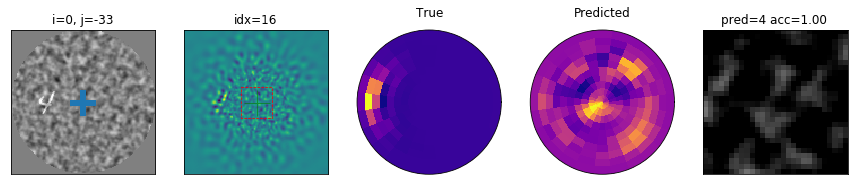

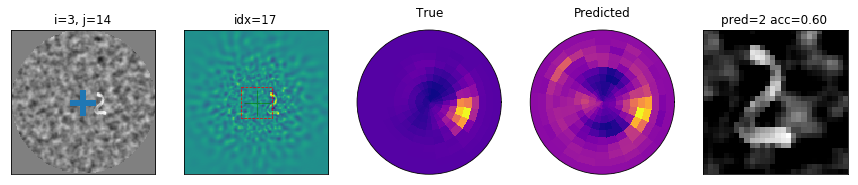

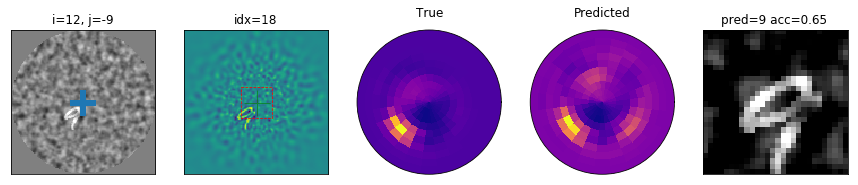

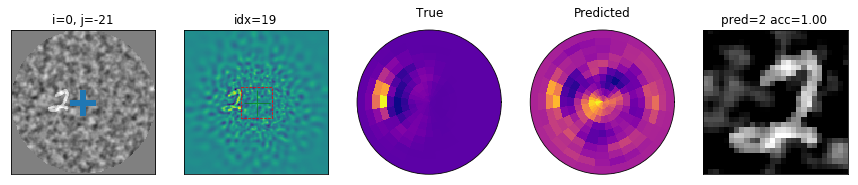

In [34]:
for idx in range(idx_start, idx_stop):
    fig = plt.figure(figsize = (15, 8))
    
    ax = fig.add_subplot(151)
    ax = where.display.show(ax, data_fullfield[idx, :, :])
    ax.set_title(f"i={positions[idx]['i_offset']}, j={positions[idx]['j_offset']}")
    
    ax = fig.add_subplot(152)
    data_retina = where.retina.retina(data_fullfield[idx, :, :])
    ax = where.retina.show(ax, where.retina.retina_invert(data_retina))
    ax.set_title(f"idx={idx}")
              
    ax = fig.add_subplot(153, projection='polar')
    ax.pcolor(where.retina.theta, where.retina.log_r, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title("True")

    ax = fig.add_subplot(154, projection='polar')
    ax.pcolor(where.retina.theta, where.retina.log_r, pred_accuracy_colliculus[idx, :].reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title("Predicted")

    i_pred, j_pred = where.index_prediction(pred_accuracy_colliculus[idx, :])
    ax = fig.add_subplot(155)                 
    ax = where.display.show(ax, where.extract(data_fullfield[idx, :, :], i_pred, j_pred), do_cross=False)
    result = '' if pred[idx]==label[idx].numpy() else 'FALSE'
    ax.set_title(f"pred={pred[idx]} acc={proba[idx,pred[idx]]:.2f} {result}")
                 

testing on the test set:

In [36]:
correct = where.test()
print('Average accuracy on the test set = ', correct.mean())

Average accuracy on the test set =  0.38839999999999997


# accuracy as a function of eccentricity


In [40]:
N_eccentricities = 9

In [41]:
ecc_max=.8
eccentricities = args.N_pic / 2 * ecc_max * (1/args.rho)**(args.N_eccentricity - np.arange(N_eccentricities))

In [42]:
eccentricities

array([ 1.6484616 ,  2.32433085,  3.2773065 ,  4.62100217,  6.51561306,
        9.18701441, 12.95369032, 18.26470335, 25.75323173])

In [43]:
def test_eccentricities(N_eccentricities=9, ecc_max=.8, do_control=False):
    import torch
    from torch.autograd import Variable

    eccentricities = args.N_pic / 2 * ecc_max * (1/args.rho)**(args.N_eccentricity - np.arange(N_eccentricities))
    #eccentricities = np.linspace(where.args.offset_max, 0, N_eccentricities, endpoint=False)
    batch_size = where.args.test_batch_size # data.shape[0]
    from retina import get_data_loader
    loader_test = get_data_loader(batch_size=1, train=False, 
                                  mean=where.args.mean, std=where.args.std, seed=where.args.seed+10)
        
    accuracy_mean, accuracy_std = [], []
    for eccentricity in eccentricities:

        retina_data = np.zeros((batch_size, where.retina.vsize))
        labels = np.zeros((batch_size))
        data_fullfield = np.zeros((batch_size, where.args.N_pic, where.args.N_pic))        
        accuracy_colliculus = np.zeros((batch_size, where.args.N_azimuth * where.args.N_eccentricity))

        for i in range(batch_size):
            data, label = next(iter(loader_test))
            data_fullfield[i, :, :], i_offset, j_offset = where.display.draw(data[0, 0, :, :].numpy(), 
                                                                   radius=eccentricity)
            positions.append(dict(i_offset=i_offset, j_offset=j_offset))
            retina_data[i, :]  =  where.retina.retina(data_fullfield[i, :, :])
            labels[i] = label
        labels =  Variable(torch.FloatTensor(labels))
        retina_data =  Variable(torch.FloatTensor(retina_data))
        pred_accuracy_colliculus = where.pred_accuracy(retina_data)
        
        accuracy_ = where.test_what(data_fullfield, pred_accuracy_colliculus, labels.squeeze(), do_control=do_control)
        accuracy_mean.append(accuracy_.mean())
        accuracy_std.append(accuracy_.std()) # TODO fit with beta distribution
        
    return eccentricities, np.array(accuracy_mean), np.array(accuracy_std)

In [ ]:
eccentricities, accuracy_mean, accuracy_std = test_eccentricities(N_eccentricities)
print('eccentricities=', eccentricities, ', accuracy_data=', accuracy_mean, ' +/- ', accuracy_std)

eccentricities, ctl_accuracy_mean, ctl_accuracy_std = test_eccentricities(N_eccentricities, do_control=True)
print('eccentricities=', eccentricities, ', ctl_accuracy_data=', ctl_accuracy_mean, ' +/- ', ctl_accuracy_std)

eccentricities= [ 1.6484616   2.32433085  3.2773065   4.62100217  6.51561306  9.18701441
 12.95369032 18.26470335 25.75323173] , accuracy_data= [0.6642 0.6487 0.63   0.6059 0.5276 0.4993 0.5052 0.4432 0.3399]  +/-  [0.47226937 0.47737649 0.48280431 0.48865652 0.49923766 0.49999951
 0.49997296 0.49676328 0.47367498]


In [ ]:
figwidth = 15
fig = plt.figure(figsize = (figwidth, figwidth/1.618))
ax_D = fig.add_subplot(1, 1, 1)
width = .8*np.abs(np.gradient(eccentricities)[0])
ax_D.bar(eccentricities, accuracy_mean, width=width, alpha = .7, label = 'One saccade')#yerr=accuracy_std, 
# TODO what instead? ax_D.bar(eccentricities, accuracy_data, alpha = .5, label = 'No saccade') #accuracy_map[27,27:55])
ax_D.bar(eccentricities, ctl_accuracy_mean, width=width, color='orange', alpha = .7, label = 'No saccade')
ax_D.plot([eccentricities.min()-width/2, eccentricities.max()+width/2], [0.1]*2, ':', c='k', label = 'Baseline')
plt.legend(loc='best')
#ax_D.set_title('Class accuracy', fontsize = 14)
ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 12)
ax_D.set_xticks(eccentricities)
ax_D.set_xticklabels(['%.1f' % d for  d in eccentricities])
ax_D.set_ylim([0,1]);

# summary


In [ ]:
fig = plt.figure(figsize = (figwidth, figwidth/2.5))#1.618))
ax_A = plt.subplot(1, 4, 1) 
data_retina = where.retina.retina(data_fullfield[idx, :, :])
ax_A = where.retina.show(ax_A, where.retina.retina_invert(data_retina))
    
ax_B = plt.subplot(2, 4, 2, projection='polar', autoscale_on=False)
ax_B.pcolor(where.retina.theta, where.retina.log_r, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)))
ax_B.grid('off')
plt.title('True', fontsize = 14)
ax_B.set_yticklabels([])
ax_B.set_xticklabels([])

ax_Bb = plt.subplot(2, 4, 6, projection='polar')
ax_Bb.pcolor(where.retina.theta, where.retina.log_r, pred_accuracy_colliculus[idx, :].reshape((args.N_azimuth, args.N_eccentricity)))
ax_Bb.set_title('Predicted', fontsize = 14)
ax_Bb.set_yticklabels([])
ax_Bb.set_xticklabels([])

ax_C = plt.subplot(1, 4, 3)
data_fullfield_ = where.display.place_object(data[idx, 0, :, :].numpy(), 0, 0)
input_vector  =  where.retina.retina(data_fullfield_)
ax_C = where.retina.show(ax_C, where.retina.retina_invert(input_vector))
i_pred, j_pred = where.index_prediction(pred_accuracy_colliculus[idx, :])
#ax_A.arrow(64.5, 64.5, j_pred, i_pred, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
ax_C.arrow(args.N_pic//2+j_pred+14, args.N_pic//2+i_pred+14, -j_pred, -i_pred, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
ax_C.arrow(args.N_pic//2+j_pred+14, args.N_pic//2+i_pred-14, -j_pred, -i_pred, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')

ax_D = plt.subplot(1, 4, 4)
#width = .8*np.abs(np.gradient(eccentricities)[0])
width = .3*np.abs(eccentricities)
ax_D.bar(eccentricities, accuracy_mean, width=width, color='blue', alpha = .5, label = 'One saccade')
ax_D.bar(eccentricities, ctl_accuracy_mean, width=width, color='orange', alpha = .5, label = 'No saccade')
width = .5
ax_D.plot([eccentricities.min()-width/2, eccentricities.max()+width/2], [0.1]*2, ':', c='k', label = 'Baseline')
#ax_D.plot([eccentricities.min()-width/2, eccentricities.max()+width/2], [acc_max]*2, ':', c='k', label = 'Max')

plt.legend(loc='upper right')
ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 12)
ax_D.set_ylim([0,1])
ax_D.set_xscale('log')
ax_D.set_xticks(eccentricities)
ax_D.set_xticklabels(['%.1f' % d for  d in eccentricities])
ax_D.set_xlim([1.3,30])

for ax, text in [[ax_A, 'DIS'], [ax_C, 'SAC']]:
    ax.text(4, 15, text, fontsize=24,
          bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
          ha='left', va='center') 

offset = -.015
for ax, text, x_offset, y_offset in [[ax_A, 'A', offset, 1.15], [ax_B, 'B', -.25, 1.225], [ax_C, 'C', offset, 1.15], [ax_D, 'D', offset, 1.15]]:
    ax.text(x_offset, y_offset, '(' + text + ')', fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center', transform=ax.transAxes) 

# pos : [left, bottom, width, height] =    The new position of the in `.Figure` coordinates.    
plt.tight_layout()
ax_A.set_position([0.025, 0.1, .3, .45])
ax_B.set_position( [0.24, 0.375, .2, 0.2])
ax_Bb.set_position([0.24, 0.1, .2, 0.2])
ax_C.set_position([0.35, .1, .3, .45])
ax_D.set_position([0.65, .1, .3, .45])
fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.1)

# post-processing

In [ ]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

In [ ]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [ ]:
!ls  -l {figname}*